# TP4 : Travail final

# Imports et configuration

In [1]:
from collections import defaultdict
import os
import sys
import collections
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize

import yake
from collections import Counter
from wordcloud import WordCloud
from IPython.display import Image
from IPython.display import display

import spacy
from spacy.lang.fr.examples import sentences
nlp = spacy.load('fr_core_news_md')

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from unidecode import unidecode

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glmqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
path = "../data/tp4_txt/"
files = sorted(os.listdir(path))

temp_path = '../data/tmp/'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)

In [3]:
## Créer un fichier unique

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Stocker le contenu de ces fichiers dans une liste
content_list = []
for txt in txts:
    with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:
        content_list.append(f.read())

# Ecrire tout le contenu dans un fichier temporaire
with open(os.path.join(temp_path, f'tp4_all.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(content_list))

In [4]:
## Créer un fichier par journal

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Stocker le contenu de ces fichiers dans une liste
LaLibreBelgique_list = []
LePeuple_list = []
LeSoir_list = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):
        elems = txt.split("_")
        newspaper = elems[1]    
    
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if newspaper == "JB427": # La Libre
                LaLibreBelgique_list.append(f.read())

            if newspaper == "JB837": # Le Peuple
                LePeuple_list.append(f.read())

            if newspaper == "JB838": # Le Soir
                LeSoir_list.append(f.read())
    
    else:
        print(f"Anomalous file: {f}")

# Ecrire tout le contenu dans des fichiers temporaires par journaux
with open(os.path.join(temp_path, f'tp4_LaLibreBelgique.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(LaLibreBelgique_list))
with open(os.path.join(temp_path, f'tp4_LePeuple.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(LePeuple_list))
with open(os.path.join(temp_path, f'tp4_LeSoir.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(LeSoir_list))

nomJournaux = ["tp4_LaLibreBelgique.txt", "tp4_LePeuple.txt", "tp4_LeSoir.txt"]

# Exploration du corpus

In [5]:
## Taille du corpus complet

print("Nombre de fichiers dans le corpus :", len(files))

Nombre de fichiers dans le corpus : 2035


## Par année et par journal

In [6]:
all_years = [str(year) for year in range(1919,1951)] # 1951 car exclusif

count_decade = defaultdict(int)
count_year = defaultdict(int)
count_month = defaultdict(int)
count_newspapers = defaultdict(int)
covered_years = set()

for f in files:
    if "_" in f and f.endswith("txt"):
        elems = f.split("_")
        
        newspaper = elems[1]
        
        year = elems[2].split("-")[0]
        covered_years.add(year)
        decade = year[:3] + "0s"
        
        month = int(elems[2].split("-")[1])
        
        count_year[year] += 1
        count_decade[decade] += 1
        count_newspapers[newspaper] += 1
        count_month[month] += 1
    else:
        print(f"Anomalous file: {f}")

In [7]:
print(f"Il y a {count_newspapers['JB838']} fichiers du Soir, {count_newspapers['JB427']} fichiers de La Libre Belgique et {count_newspapers['JB837']} fichiers du Peuple")

Il y a 782 fichiers du Soir, 700 fichiers de La Libre Belgique et 553 fichiers du Peuple


In [8]:
missing_years = [y for y in all_years if y not in covered_years]

if missing_years :
    print(f"Années manquantes: {', '.join(missing_years)}")

else:
    print("Pas d'années manquantes")

Pas d'années manquantes


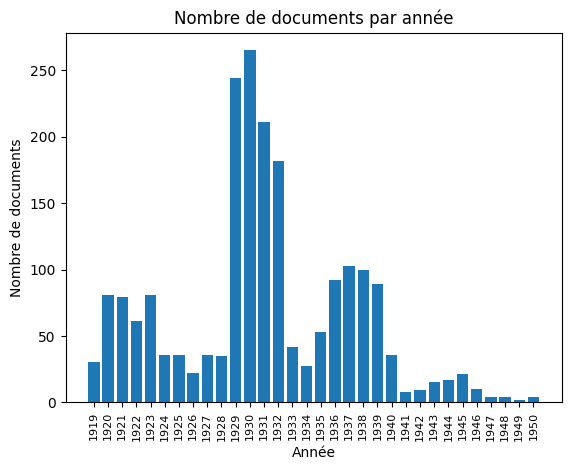

In [9]:
index = np.arange(len(count_year))
plt.bar(index, count_year.values())
plt.xlabel('Année')
plt.ylabel('Nombre de documents')
plt.xticks(index, sorted(count_year.keys()), fontsize=8, rotation=90)
plt.title('Nombre de documents par année')
plt.show()

## Vocabulaire du corpus

In [10]:
limit = 10**8

with open(temp_path + "tp4_all.txt", "r", encoding="utf-8") as f:
    text = f.read()[:limit]

In [12]:
# Dresser la liste des stopwords

sw = stopwords.words("french")
sw += [
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi"
    ]
sw = set(sw)

In [13]:
# Tokenization
words = nltk.wordpunct_tokenize(text)
print(f"{len(words)} mots trouvés dans le corpus")

# Eliminer les stopwords et les termes non alphabétiques
kept = [w.lower() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
voc = set(kept)
print(f"{len(kept)} mots conservés après tri ({len(voc)} lemmes différents)")

17941543 mots trouvés dans le corpus
6332344 mots conservés après tri (489700 lemmes différents)


In [14]:
# Mots les plus fréquents et hapax

fdist = nltk.FreqDist(kept)
print("Mots les plus fréquents :", fdist.most_common(10))
print("--")
print("Hapax :", fdist.hapaxes()[:30])

Mots les plus fréquents : [('gouvernement', 19793), ('ministre', 16715), ('bruxelles', 15683), ('pays', 13905), ('question', 13686), ('belgique', 12761), ('président', 11365), ('conseil', 10556), ('politique', 10350), ('heures', 10320)]
--
Hapax : ['cenlimesiie', 'jstiition', 'fifdaelioh', 'arjiainlstrali', 'usoowdrkdltiondesjournaui', 'tihotk', 'herbeà', 'usq', 'coiultlori', 'tomlguos', 'tnanusci', 'rmctilt', 'ponltaîues', 'exnlustae', 'horeaui', 'hjilioii', 'uonm', 'aïence', 'tviu', 'puice', 'cfej', 'ngrs', 'disman', 'ltlsiliriie', 'onijistsilatb', 'vmuîs', 'dlvbî', 'itiali', 'kkgkoluduils', 'ekor']


## Keywords

In [ ]:
# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

In [ ]:
# Récupérer le texte temporaire complet, en mode lecture ('r'), en encodage utf-8
text = open(os.path.join(temp_path, f'tp4_all.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)

kept_bi = []
kept_tri = []

for kw, score in keywords:
    words = kw.split()

    if len(words) == 2:
        kept_bi.append(kw)
        
    if len(words) == 3:
        kept_tri.append(kw)

print(f"Le fichier mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
print(f"Le fichier mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")

## Par journal

In [ ]:
# Faire la même opération pour les trois fichiers par journal

for i in nomJournaux:
    text = open(os.path.join(temp_path, i), 'r', encoding="utf-8").read()

    keywords = kw_extractor.extract_keywords(text)
    kept_bi = []
    kept_tri = []

    for kw, score in keywords:
        words = kw.split()

        if len(words) == 2:
            kept_bi.append(kw)
        
        if len(words) == 3:
            kept_tri.append(kw)

    print(f"{i} mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
    print(f"{i} mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")
    print("---")

## Exploration de trois périodes distinctes

In [ ]:
# Explorer la période 1935-1940 qu'on repère sur le graphe du nbre de doc par année

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

annees = [str(annees) for annees in range(1935,1941)]
choixFichiers = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):

        elems = txt.split("_")
        year = elems[2].split("-")[0]

        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if year in annees:
                choixFichiers.append(f.read())

    else:
        print(f"Anomalous file: {txt}")

with open(os.path.join(temp_path, f'tp4_1935-1940.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(choixFichiers))

# Appliquer une extraction de keywords

text = open(os.path.join(temp_path, "tp4_1935-1940.txt"), 'r', encoding="utf-8").read()

keywords = kw_extractor.extract_keywords(text)
kept_bi = []
kept_tri = []

for kw, score in keywords:
    words = kw.split()

    if len(words) == 2:
        kept_bi.append(kw)
        
    if len(words) == 3:
        kept_tri.append(kw)

print(f"Le fichier mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
print(f"Le fichier mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")

In [ ]:
# Idem pour la période 1919-1925

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

annees = [str(annees) for annees in range(1919, 1926)]
choixFichiers = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):

        elems = txt.split("_")
        year = elems[2].split("-")[0]

        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if year in annees:
                choixFichiers.append(f.read())

    else:
        print(f"Anomalous file: {txt}")

with open(os.path.join(temp_path, f'tp4_1919-1925.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(choixFichiers))

# Appliquer une extraction de keywords

text = open(os.path.join(temp_path, "tp4_1919-1925.txt"), 'r', encoding="utf-8").read()

keywords = kw_extractor.extract_keywords(text)
kept_bi = []
kept_tri = []

for kw, score in keywords:
    words = kw.split()

    if len(words) == 2:
        kept_bi.append(kw)
        
    if len(words) == 3:
        kept_tri.append(kw)

print(f"Le fichier mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
print(f"Le fichier mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")

In [ ]:
# Idem pour la période 1929-1933

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

annees = [str(annees) for annees in range(1929, 1934)]
choixFichiers = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):

        elems = txt.split("_")
        year = elems[2].split("-")[0]

        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if year in annees:
                choixFichiers.append(f.read())

    else:
        print(f"Anomalous file: {txt}")

with open(os.path.join(temp_path, f'tp4_1929-1933.txt'), 'w', encoding="utf-8") as f:
    f.write(' '.join(choixFichiers))

# Appliquer une extraction de keywords

text = open(os.path.join(temp_path, "tp4_1929-1933.txt"), 'r', encoding="utf-8").read()

keywords = kw_extractor.extract_keywords(text)
kept_bi = []
kept_tri = []

for kw, score in keywords:
    words = kw.split()

    if len(words) == 2:
        kept_bi.append(kw)
        
    if len(words) == 3:
        kept_tri.append(kw)

print(f"Le fichier mentionne les mots-clés suivants (bigrammes) : {', '.join(kept_bi)}...")
print(f"Le fichier mentionne les mots-clés suivants (trigrammes) : {', '.join(kept_tri)}...")

## Wordcloud

In [ ]:
## Fonction de nettoyage

def clean_text(inFile, folder=None):
    if folder is None:
        input_path = f"{inFile}"
        output_path = f"clean_{inFile}"
    else:
        input_path = f"{folder}{inFile}"
        output_path = f"{folder}clean_{inFile}"

    output = open(output_path, "w", encoding='utf-8')

    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 3 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)

    return f'Output has been written in {output_path}!'

In [ ]:
# Appliquer la fonction et vérifier les résultats

clean_text("tp4_all.txt", folder=temp_path)

with open(os.path.join(temp_path, f'clean_tp4_all.txt'), 'r', encoding="utf-8") as f:
    after = f.read()

# Calculer les mots les plus fréquents et afficher les résultats

frequencies = Counter(after.split())

print(frequencies.most_common(100))

In [ ]:
# Compléter la liste des stopwords

sw = stopwords.words("french")
sw += [
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi", 
    # Coquilles + mots sans sémantiques discrimantes d'après les mots les plus fréquents
    "heures", "grand", "jour", "lieu", "temps", "grande", "part", "mois", "matin", "soir", "aujourd", "moment", "jours", "fois", "heure", "jamais", "également", "ailleurs", "hier", "vient", "année", "certains", "cependant", "parce"
    ]
sw = set(sw)

In [ ]:
# Créer, stocker, afficher le nuage de mots

cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(temp_path, f"tp4_all.png"))
Image(filename=os.path.join(temp_path, f"tp4_all.png"))

In [ ]:
# Même procédure pour les fichiers de journaux

for i in nomJournaux:

    clean_text(i, folder=temp_path)

    with open(os.path.join(temp_path, f'clean_{i}'), 'r', encoding="utf-8") as f:
        after = f.read()

    # Calculer les mots les plus fréquents et afficher les résultats

    frequencies = Counter(after.split())

    print("Fréquences dans", i, ": ", frequencies.most_common(100))
    print("---")

    # Créer, stocker, afficher les nuages de mots

    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
    cloud.to_file(os.path.join(temp_path, f"{i}.png"))
    Image(filename=os.path.join(temp_path, f"{i}.png"))

## NER

In [ ]:
# Charger le texte
n=100000
text_NER = open(os.path.join(temp_path, f"tp4_all.txt"), 'r', encoding="utf-8").read()[:n]

# Traiter le texte

doc = nlp(text_NER)

# Compter les entités (personnes, lieux, organisations)

people = defaultdict(int)
places = defaultdict(int)
orga = defaultdict(int)

for ent in doc.ents:
    if ent.label_ == "PER" and len(ent.text) > 3:
        people[ent.text] += 1
    elif ent.label_ == "LOC" and len(ent.text) > 3:
        places[ent.text] += 1
    elif ent.label_ == "ORG" and len(ent.text) > 3:
        orga[ent.text] += 1

# Trier

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
sorted_places = sorted(places.items(), key=lambda kv: kv[1], reverse=True)
sorted_orga = sorted(orga.items(), key=lambda kv: kv[1], reverse=True)

In [ ]:
# Imprimer les 50 premières personnes

for person, freq in sorted_people[:10]:
    print(f"{person} apparait {freq} fois dans le corpus")

In [ ]:
# Imprimer les 50 premiers lieux

for place, freq in sorted_places[:10]:
    print(f"{place} apparait {freq} fois dans le corpus")

In [ ]:
# Imprimer les 50 premières organisations

for orga, freq in sorted_orga[:10]:
    print(f"{orga} apparait {freq} fois dans le corpus")

In [ ]:
# Selon les 3 groupes d'années

nomAnnees = ["tp4_1919-1925.txt", "tp4_1929-1933.txt", "tp4_1935-1940.txt"]

for i in nomAnnees :

    # Charger le texte
    n=100000
    text_NER = open(os.path.join(temp_path, i), 'r', encoding="utf-8").read()[:n]

    # Traiter le texte

    doc = nlp(text_NER)

    # Compter les entités (personnes, lieux, organisations)

    people = defaultdict(int)
    places = defaultdict(int)
    orga = defaultdict(int)

    for ent in doc.ents:
        if ent.label_ == "PER" and len(ent.text) > 3:
            people[ent.text] += 1
        elif ent.label_ == "LOC" and len(ent.text) > 3:
            places[ent.text] += 1
        elif ent.label_ == "ORG" and len(ent.text) > 3:
            orga[ent.text] += 1

    # Trier

    sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)
    sorted_places = sorted(places.items(), key=lambda kv: kv[1], reverse=True)
    sorted_orga = sorted(orga.items(), key=lambda kv: kv[1], reverse=True)

    # Imprimer

    print(i)
    print("Personnes :")
    for person, freq in sorted_people[:5]:
        print(f"{person} apparait {freq} fois dans le corpus")
    
    print("Lieux :")
    for place, freq in sorted_places[:5]:
        print(f"{place} apparait {freq} fois dans le corpus")

    print("Organisations :")
    for orga, freq in sorted_orga[:5]:
        print(f"{orga} apparait {freq} fois dans le corpus")
    
    print("---")

# Clustering

In [17]:
# Création d'une fonction de pré-traitement

def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

# Instancier le modèle TF-IDF avec ses arguments

vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5, #ignorer les mots apparaissant dans plus de 50% des docs
    min_df=0.1, #ignorer les mots apparaissant dans moins de 10% des docs
    lowercase=True #tout mettre en minuscules
)

In [21]:
files = [f for f in sorted(os.listdir(path))]

texts = [open(path + f, "r", encoding="utf-8").read() for f in files]

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

tfidf_vectors = vectorizer.fit_transform(texts)

# Imprimer les détails de la matrice

tfidf_vectors

<2035x4015 sparse matrix of type '<class 'numpy.float64'>'
	with 1702752 stored elements in Compressed Sparse Row format>

## Faire les clusters

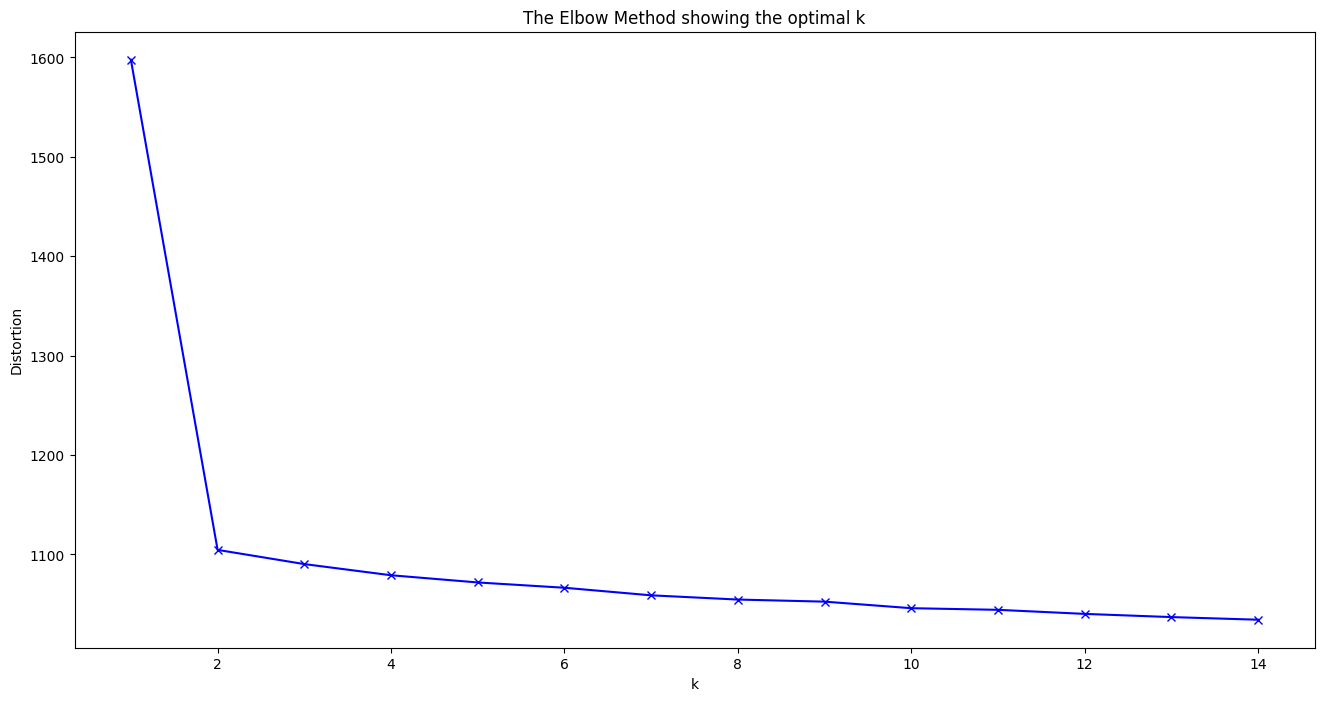

In [22]:
# Elbow method pour déterminer le nbre de clusters optimal

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_vectors)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [52]:
# Nbre clusters

N_CLUSTERS = 2

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [55]:
# Afficher le résultat du clustering (un dictionnaire)

dict(clustering)[1]

['KB_JB427_1919-03-31_01-00001.txt',
 'KB_JB427_1919-05-31_01-00001.txt',
 'KB_JB427_1919-06-19_01-00002.txt',
 'KB_JB427_1919-08-08_01-00002.txt',
 'KB_JB427_1919-08-20_01-00002.txt',
 'KB_JB427_1919-09-07_01-00001.txt',
 'KB_JB427_1919-09-08_01-00002.txt',
 'KB_JB427_1919-09-09_01-00002.txt',
 'KB_JB427_1919-09-11_01-00003.txt',
 'KB_JB427_1919-09-24_01-00002.txt',
 'KB_JB427_1919-09-27_01-00002.txt',
 'KB_JB427_1919-10-13_01-00001.txt',
 'KB_JB427_1919-10-14_01-00002.txt',
 'KB_JB427_1919-10-19_01-00002.txt',
 'KB_JB427_1919-10-29_01-00002.txt',
 'KB_JB427_1919-11-02_01-00002.txt',
 'KB_JB427_1919-12-03_01-00002.txt',
 'KB_JB427_1920-03-03_01-00002.txt',
 'KB_JB427_1920-03-03_01-00003.txt',
 'KB_JB427_1920-03-10_01-00002.txt',
 'KB_JB427_1920-03-10_01-00003.txt',
 'KB_JB427_1920-03-20_01-00002.txt',
 'KB_JB427_1920-03-26_01-00004.txt',
 'KB_JB427_1920-04-17_01-00001.txt',
 'KB_JB427_1920-05-07_01-00003.txt',
 'KB_JB427_1920-05-15_01-00003.txt',
 'KB_JB427_1920-05-31_01-00002.txt',
 

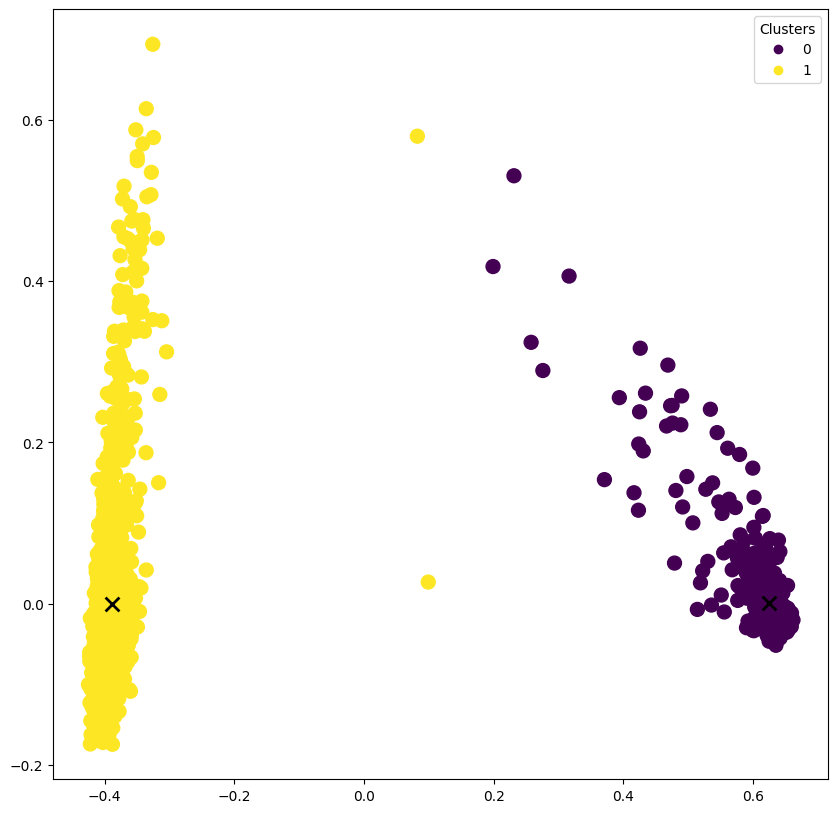

In [30]:
# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

## Explorer les clusters

In [31]:
# Créer des fichiers tmp avec les textes des clusters

for key in clustering.keys():
    
    tmp_content_list = []

    for txt in clustering[key]:
        
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:
            tmp_content_list.append(f.read())
        
    with open(os.path.join(temp_path, f'tp4_cluster_{key}.txt'), 'w', encoding="utf-8") as f:
        f.write(' '.join(tmp_content_list))   

In [32]:
# Regarder le nombre de documents par cluster

for key in clustering.keys():
    print(f"Nombre de documents dans le cluster {key} : {len(clustering[key])}")

Nombre de documents dans le cluster 1 : 1255
Nombre de documents dans le cluster 0 : 780


Cluster n° 1, Nbre doc : 1255, Counter({'1929': 150, '1930': 150, '1931': 130, '1932': 103, '1938': 65, '1920': 60, '1937': 60, '1923': 55, '1939': 53, '1936': 51, '1921': 49, '1922': 43, '1935': 29, '1924': 28, '1927': 26, '1928': 26, '1925': 24, '1919': 23, '1933': 22, '1940': 21, '1934': 19, '1926': 17, '1948': 12, '1949': 12, '1947': 10, '1950': 6, '1945': 5, '1946': 5, '1944': 1})


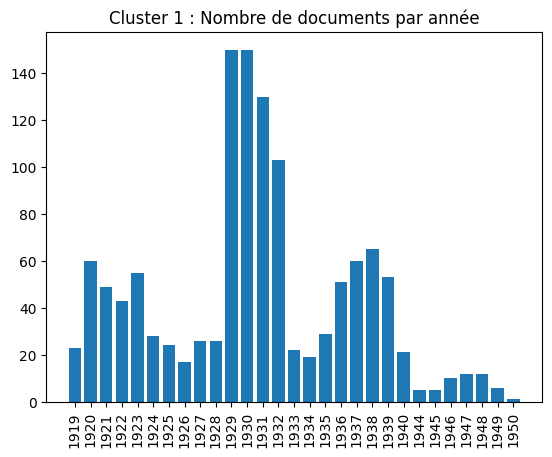

Cluster n° 0, Nbre doc : 780, Counter({'1930': 115, '1929': 94, '1931': 81, '1932': 79, '1937': 43, '1936': 41, '1939': 36, '1938': 35, '1921': 30, '1923': 26, '1935': 24, '1920': 21, '1933': 20, '1922': 18, '1940': 15, '1925': 12, '1927': 10, '1928': 9, '1949': 9, '1924': 8, '1934': 8, '1919': 7, '1926': 5, '1947': 5, '1948': 5, '1941': 4, '1943': 4, '1946': 4, '1950': 4, '1944': 3, '1945': 3, '1942': 2})


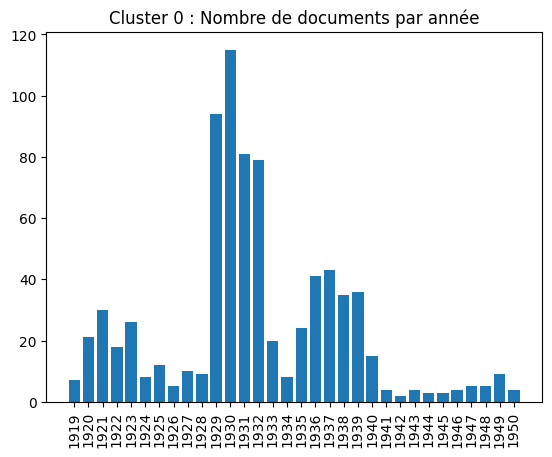

In [42]:
# Regarder la distribution des clusters selon les années

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_year(filename):
    year = (re.search("([0-9]{4})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
years_per_cluster = []
for key in clustering.keys():
    years_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        years_per_cluster[key].append(get_year(i))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(years_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(sorted(tmp_counter.keys()), tmp_counter.values())
    plt.xticks(rotation=90)
    plt.title(f"Cluster {key} : Nombre de documents par année")
    plt.show()


In [43]:
# Regarder les mots-clés de chaque cluster

for key in clustering.keys():

    # Instantier l'extracteur de mots clés en fr + les 50 premiers
    kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

    # Récupérer le texte sauvegardé ci-dessus
    text = open(os.path.join(temp_path, f'tp4_cluster_{key}.txt'), 'r', encoding="utf-8").read()

    # Extraire les mots clés de ce texte
    keywords = kw_extractor.extract_keywords(text)

    # Ne garder que les bigrammes / trigrammes
    kept_bigrams = []
    kept_trigrams = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2: # si c'est un bigramme
            kept_bigrams.append(kw)
        elif len(words) == 3: # si c'est un trigramme
            kept_trigrams.append(kw)

    print(f"Bigrammes récurrents, cluster n° {key} : {kept_bigrams}")
    print(f"Trigrammes récurrents, cluster n° {key} : {kept_trigrams}")
    print("")

Keywords, cluster n° 1 : [('Parti ouvrier belge', 8.114855660508098e-08), ('gouvernement van Zeeland', 8.963349242834775e-08), ('jour LIBRE BELGIQUE', 1.1075611661622794e-07), ('Libre Belgique', 1.3801258010558154e-07), ('VAN CAUWELAERT', 1.830801613412383e-07), ('Anvers Bruxelles Gand', 2.1068665514212594e-07), ('LIBRE BELGIQUE ANNONCES', 2.2060171802693984e-07), ('GRAND BRUXELLES Bruxelles', 2.694644720849571e-07), ('parti socialiste belge', 2.982966904199707e-07), ('OUVRIER BELGE BRUXELLES', 3.0248243415642653e-07), ('Bruxelles CHAMBRE Catholiques', 3.180093231068556e-07), ('Bloc catholique belge', 3.8625002933587806e-07), ('BRUXELLES', 4.111964562825525e-07), ('parti catholique', 4.795568731512698e-07), ('parti catholique belge', 5.10649569070986e-07), ('Belgique', 5.38865757866288e-07), ('van Zeeland', 5.568292274787606e-07), ('gouvernement belge', 5.659269102642036e-07), ('ministres catholiques flamands', 5.666828459824608e-07), ('Van', 5.813949263561754e-07), ('Bruxelles dimanch

Cluster n° 1, Nbre doc : 1255, Counter({'JB427': 700, 'JB837': 553, 'JB838': 2})


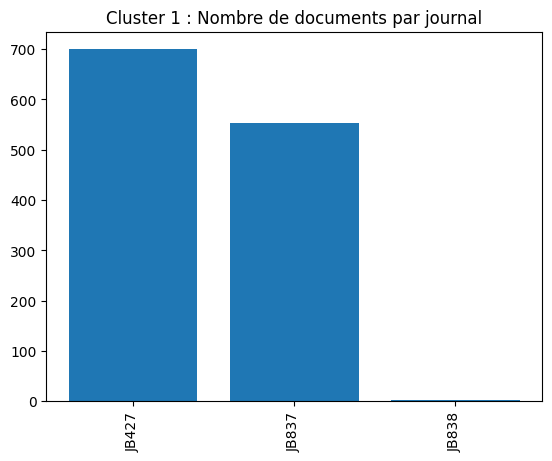

Cluster n° 0, Nbre doc : 780, Counter({'JB838': 780})


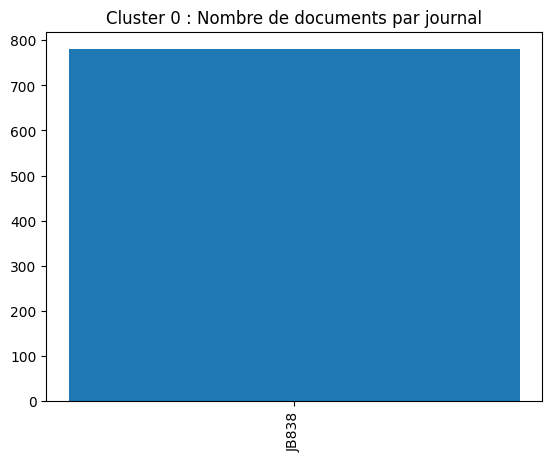

In [56]:
# Regarder la distribution des clusters selon les journaux

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_newspaper(filename):
    year = (re.search("(JB[0-9]{3})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
np_per_cluster = []
for key in clustering.keys():
    np_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        np_per_cluster[key].append(get_newspaper(i))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(np_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(sorted(tmp_counter.keys()), tmp_counter.values())
    plt.xticks(rotation=90)
    plt.title(f"Cluster {key} : Nombre de documents par journal")
    plt.show()

In [59]:
# Journal par journal
# Semble demander des listes de fichiers et pas un fichier global?

txts = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

LaLibreBelgique_list = []
LePeuple_list = []
LeSoir_list = []

for txt in txts:
    if "_" in txt and txt.endswith("txt"):
        elems = txt.split("_")
        newspaper = elems[1]    
    
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:

            if newspaper == "JB427": # La Libre
                LaLibreBelgique_list.append(f.read())

            if newspaper == "JB837": # Le Peuple
                LePeuple_list.append(f.read())

            if newspaper == "JB838": # Le Soir
                LeSoir_list.append(f.read())
    
    else:
        print(f"Anomalous file: {f}")

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

tfidf_vectors_LLB = vectorizer.fit_transform(LaLibreBelgique_list)
tfidf_vectors_LP = vectorizer.fit_transform(LePeuple_list)
tfidf_vectors_LS = vectorizer.fit_transform(LeSoir_list)

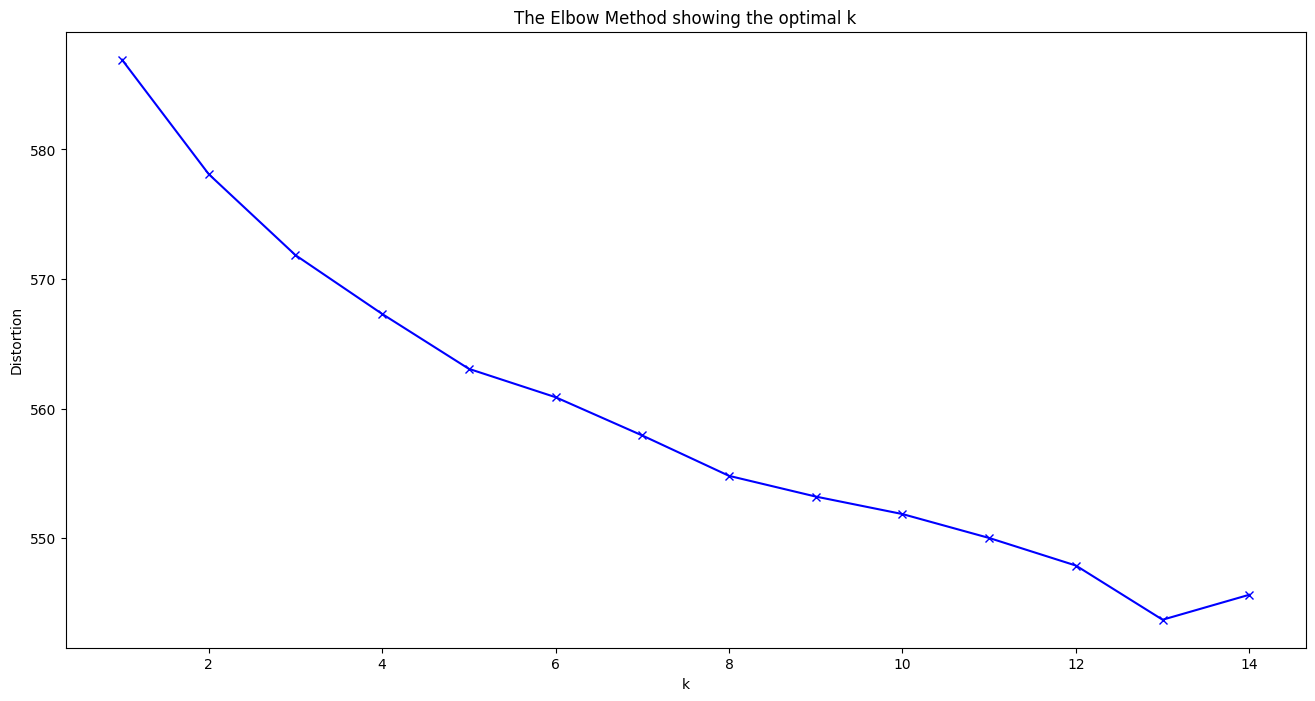

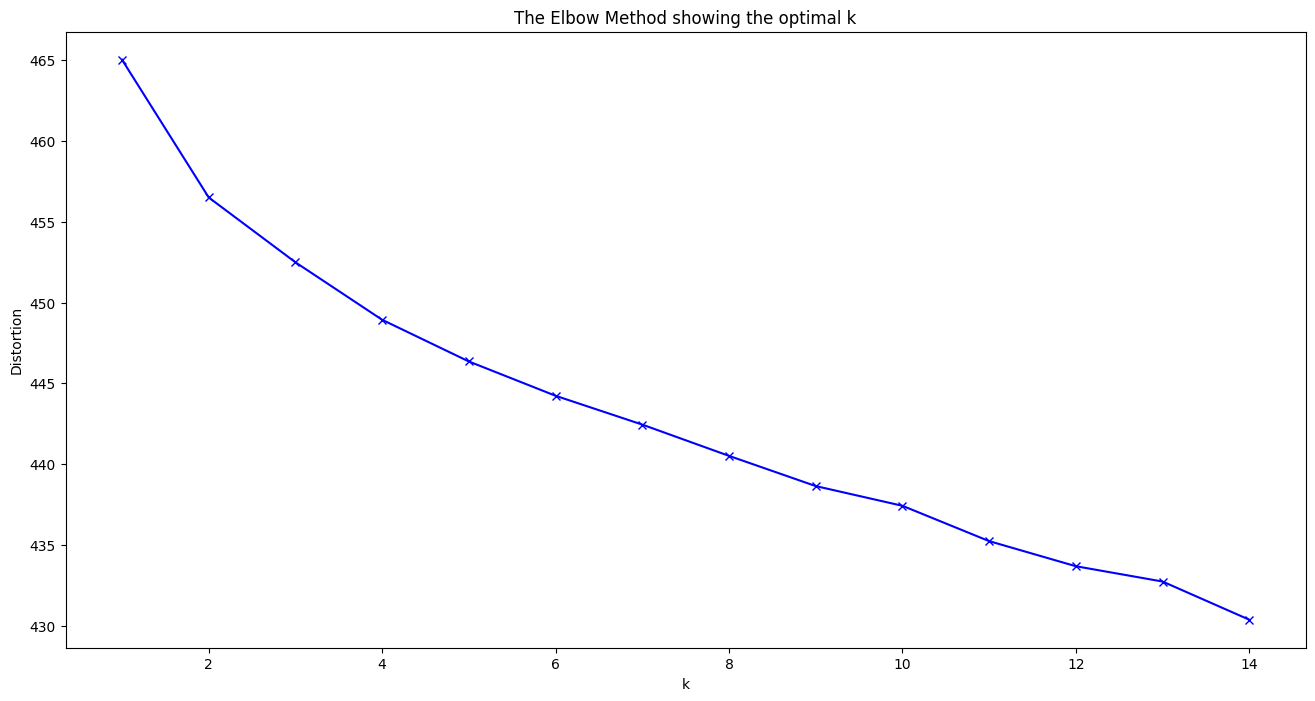

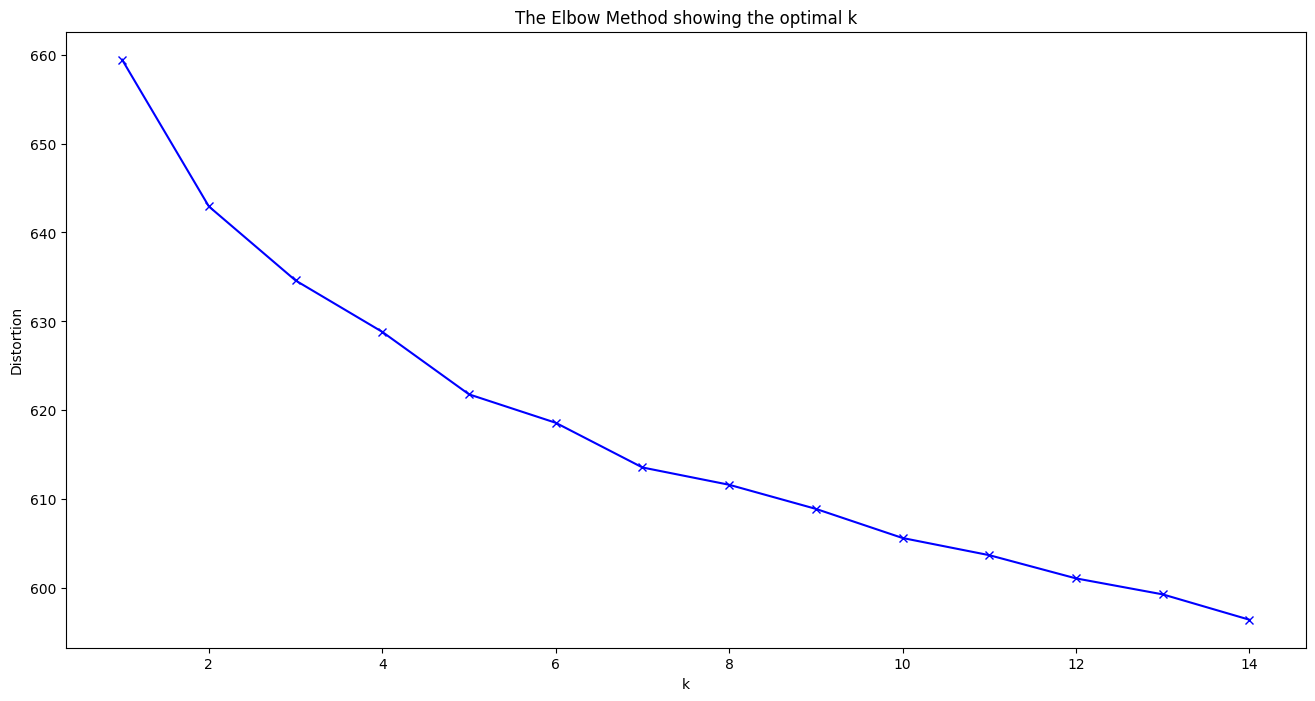

In [79]:
tfidf_vectors_list = [tfidf_vectors_LLB, tfidf_vectors_LP, tfidf_vectors_LS]

# Elbow method pour déterminer le nbre de clusters optimal

for i in tfidf_vectors_list:

    distortions = []
    K = range(1,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(i)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title(f'The Elbow Method showing the optimal k')
    plt.show()

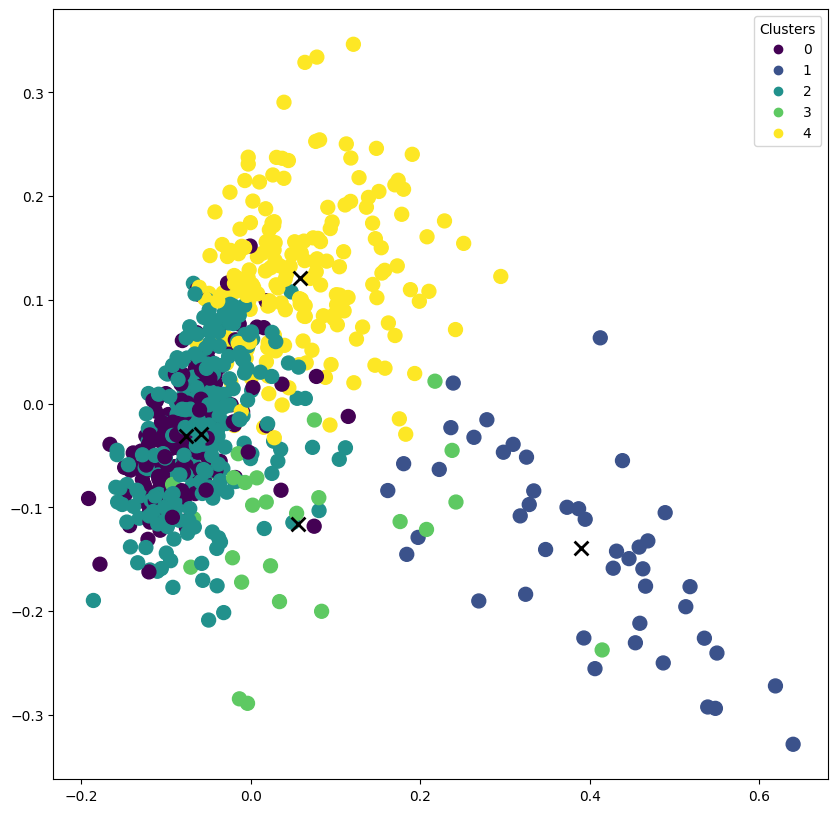

Nombre de documents dans le cluster 4 : 187
Nombre de documents dans le cluster 0 : 205
Nombre de documents dans le cluster 2 : 237
Nombre de documents dans le cluster 1 : 44
Nombre de documents dans le cluster 3 : 27
Cluster n° 4, Nbre doc : 187, Counter({'1929': 19, '1920': 18, '1930': 18, '1919': 14, '1921': 13, '1922': 11, '1923': 11, '1931': 11, '1924': 9, '1932': 9, '1937': 9, '1928': 6, '1938': 6, '1927': 5, '1933': 5, '1925': 4, '1936': 4, '1939': 4, '1926': 3, '1947': 3, '1935': 2, '1948': 2, '1940': 1})


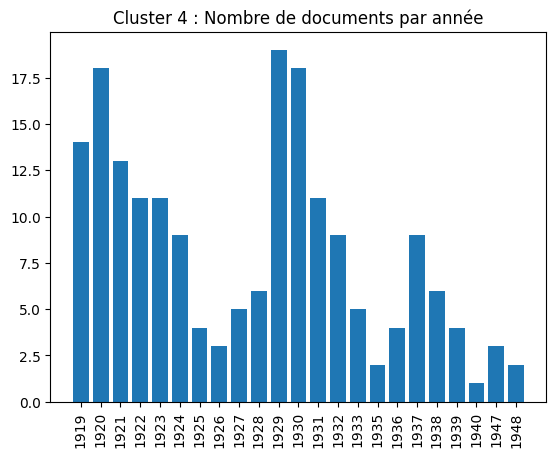

Cluster n° 0, Nbre doc : 205, Counter({'1929': 35, '1930': 26, '1931': 19, '1922': 17, '1923': 12, '1921': 11, '1924': 11, '1932': 11, '1920': 10, '1925': 9, '1927': 7, '1928': 5, '1937': 5, '1936': 4, '1939': 4, '1940': 4, '1926': 3, '1934': 3, '1935': 3, '1919': 2, '1938': 2, '1945': 1, '1947': 1})


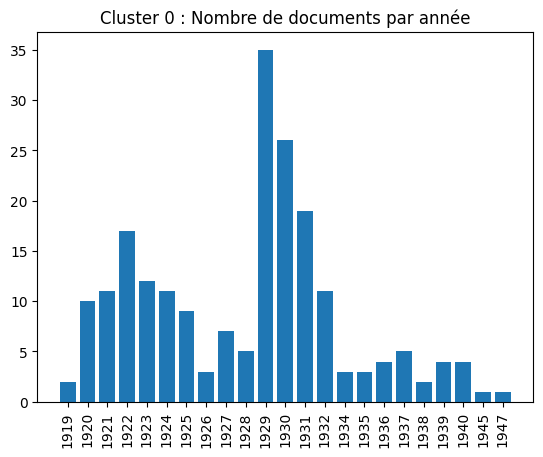

Cluster n° 2, Nbre doc : 237, Counter({'1931': 34, '1930': 29, '1929': 28, '1932': 24, '1936': 16, '1939': 16, '1938': 15, '1935': 11, '1937': 9, '1940': 7, '1921': 6, '1949': 6, '1920': 4, '1928': 4, '1948': 4, '1950': 4, '1923': 3, '1925': 3, '1926': 2, '1927': 2, '1933': 2, '1934': 2, '1947': 2, '1919': 1, '1922': 1, '1924': 1, '1946': 1})


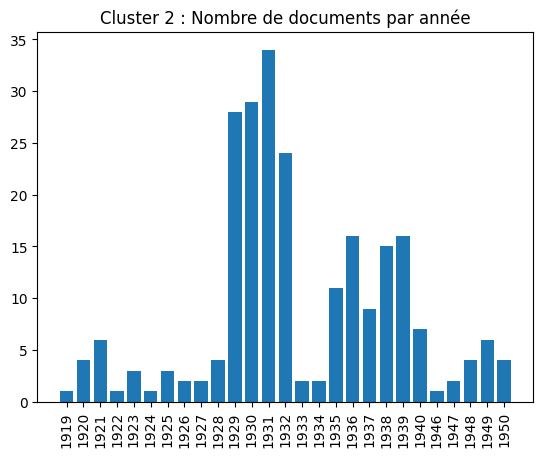

Cluster n° 1, Nbre doc : 44, Counter({'1932': 7, '1920': 6, '1933': 5, '1938': 5, '1921': 4, '1931': 3, '1936': 3, '1930': 2, '1935': 2, '1939': 2, '1922': 1, '1923': 1, '1926': 1, '1934': 1, '1945': 1})


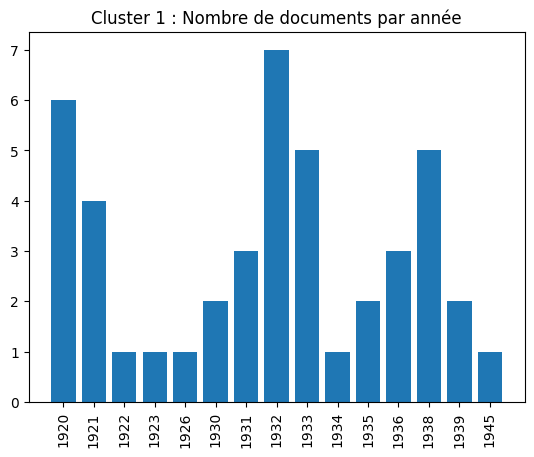

Cluster n° 3, Nbre doc : 27, Counter({'1931': 5, '1938': 4, '1940': 3, '1930': 2, '1932': 2, '1936': 2, '1929': 1, '1934': 1, '1935': 1, '1937': 1, '1939': 1, '1947': 1, '1948': 1, '1949': 1, '1950': 1})


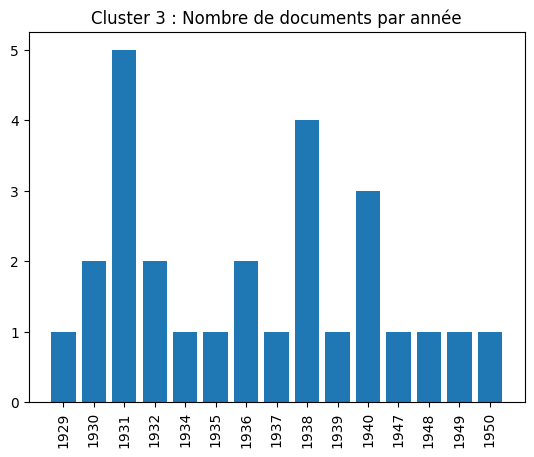

Keywords, cluster n° 4 : [('BRUXELLES', 1.0207815262987903e-05), ('Van', 1.0389613783275883e-05), ('cardinal Van Roey', 1.3136223779034063e-05), ('BRUXELLES Dimanche matin', 1.5375805277743252e-05), ('Belgique', 1.5555770654490014e-05), ('Libre Belgique', 1.6554815211697888e-05), ('VAN CAUWELAERT', 1.84244491467294e-05), ("C'est", 2.400474967438572e-05), ("cours d'une réunion", 2.6124613740236712e-05), ("qu'il", 2.7079608644811145e-05), ('chambre', 2.9192116947987987e-05), ('conseil', 3.031797417316337e-05), ('ministre', 3.090660882851683e-05), ('Mgr Van Roey', 3.0965225783843505e-05), ("d'un", 3.1219247128377536e-05), ('France', 3.19296423333112e-05), ("d'une", 3.222438911048305e-05), ('Paris', 3.246998106933065e-05), ('conseil communal', 3.404414832584869e-05), ('parti catholique', 3.4564532213357853e-05), ('gouvernement', 3.786947275131277e-05), ('président Van COURS', 4.056770821425074e-05), ("cours d'une", 4.121588333142896e-05), ('dimanche', 4.1286897512945065e-05), ('président',

In [81]:
## Exemple avec La Libre Belgique

# Nbre clusters

N_CLUSTERS = 5

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors_LLB)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors_LLB.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")
plt.show()

# Créer des fichiers tmp avec les textes des clusters

for key in clustering.keys():
    
    tmp_content_list = []

    for txt in clustering[key]:
        
        with open(os.path.join(path, txt), 'r', encoding="utf-8") as f:
            tmp_content_list.append(f.read())
        
    with open(os.path.join(temp_path, f'tp4_LLB_cluster_{key}.txt'), 'w', encoding="utf-8") as f:
        f.write(' '.join(tmp_content_list))   

# Regarder le nombre de documents par cluster

for key in clustering.keys():
    print(f"Nombre de documents dans le cluster {key} : {len(clustering[key])}")

# Regarder la distribution des clusters selon les années

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_year(filename):
    year = (re.search("([0-9]{4})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
years_per_cluster = []
for key in clustering.keys():
    years_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        years_per_cluster[key].append(get_year(i))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(years_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(sorted(tmp_counter.keys()), tmp_counter.values())
    plt.xticks(rotation=90)
    plt.title(f"Cluster {key} : Nombre de documents par année")
    plt.show()

# Regarder les mots-clés de chaque cluster

for key in clustering.keys():

    # Instantier l'extracteur de mots clés en fr + les 50 premiers
    kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

    # Récupérer le texte sauvegardé ci-dessus
    text = open(os.path.join(temp_path, f'tp4_LLB_cluster_{key}.txt'), 'r', encoding="utf-8").read()

    # Extraire les mots clés de ce texte
    keywords = kw_extractor.extract_keywords(text)

    # Ne garder que les bigrammes / trigrammes
    kept_bigrams = []
    kept_trigrams = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2: # si c'est un bigramme
            kept_bigrams.append(kw)
        elif len(words) == 3: # si c'est un trigramme
            kept_trigrams.append(kw)

    print(f"Bigrammes récurrents, cluster n° {key} : {kept_bigrams}")
    print(f"Trigrammes récurrents, cluster n° {key} : {kept_trigrams}")
    print("")

# Word Embeddings

In [82]:
# Sentence tokenizer

def sentence_tokenizer(inFile, outFile, LIMIT=None):

    with open(outFile, 'w', encoding="utf-8") as output:
        with open(inFile, encoding="utf-8", errors="backslashreplace") as f:
            content = f.readlines()
            content = content[:LIMIT] if LIMIT is not None else content
            n_lines = len(content)
            for i, line in enumerate(content):
                if i % 100 == 0:
                    print(f'processing line {i}/{n_lines}')
                sentences = sent_tokenize(line)
                for sent in sentences:
                    output.write(sent + "\n")
    print("Done")

In [84]:
for i in nomJournaux:
    inFile = f"{temp_path}{i}"
    outFile = f"{temp_path}sents_{i}"

    sentence_tokenizer(inFile, outFile)
    print("Done", i)

processing line 0/1
Done
Done tp4_LaLibreBelgique.txt
processing line 0/1
Done
Done tp4_LePeuple.txt
processing line 0/1
Done
Done tp4_LeSoir.txt


In [85]:
# Création d'un objet qui streame les lignes d'un fichier pour économiser de la RAM

class MySentences(object):
    """Tokenize and Lemmatize sentences""" # Permet de tokenizer des "doubles" mots, par ex "premier" + "ministre" va être considéré comme un token "premier ministre"
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]


for i in nomJournaux:
    infile = f"{temp_path}sents_{i}"
    sentences = MySentences(infile)
    print("Done MySentences", i)

    # Création de l'objet 'phrases' = "dictionnaire d'expressions multi-mots associées à un score", dont les clés correspondent aux termes du corpus

    bigram_phrases = Phrases(sentences)
    print("Done Phrases", i)

    # Conversion des objets 'phrases' en objet 'phraser' = version light du 'phrases' -> convertit certains unigrams en bigrams s'ils sont pertinents

    bigram_phraser = Phraser(phrases_model=bigram_phrases)
    print("Done Phraser", i)

    # Sauvegarder l'objet Phraser des bigrammes

    with open(f"{temp_path}bigrams_{i}.p", 'wb') as f:
        pickle.dump(bigram_phraser, f)
    print("Done Pickle", i)


Done MySentences tp4_LaLibreBelgique.txt
Done Phrases tp4_LaLibreBelgique.txt
Done Phraser tp4_LaLibreBelgique.txt
Done Pickle tp4_LaLibreBelgique.txt
Done MySentences tp4_LePeuple.txt
Done Phrases tp4_LePeuple.txt
Done Phraser tp4_LePeuple.txt
Done Pickle tp4_LePeuple.txt
Done MySentences tp4_LeSoir.txt
Done Phrases tp4_LeSoir.txt
Done Phraser tp4_LeSoir.txt
Done Pickle tp4_LeSoir.txt


In [88]:
for i in nomJournaux:

    # Ouvrir l'objet Phraser des bigrammes

    bigram_phraser = pickle.load(open(f"{temp_path}bigrams_{i}.p", "rb"))

    trigram_phrases = Phrases(bigram_phraser[sentences])
    print("Done Phrases", i)

    # Conversion en objet Phraser et sauvegarde du Phraser des trigrammes

    trigram_phraser = Phraser(phrases_model=trigram_phrases)
    print("Done Phraser", i)

    with open(f"{temp_path}trigrams_{i}.p", 'wb') as f:
        pickle.dump(trigram_phraser, f)
    print("Done Pickle", i)

Done Phrases tp4_LaLibreBelgique.txt
Done Phraser tp4_LaLibreBelgique.txt
Done Pickle tp4_LaLibreBelgique.txt
Done Phrases tp4_LePeuple.txt
Done Phraser tp4_LePeuple.txt
Done Pickle tp4_LePeuple.txt
Done Phrases tp4_LeSoir.txt
Done Phraser tp4_LeSoir.txt
Done Pickle tp4_LeSoir.txt


In [92]:
for i in nomJournaux:

    bigram_phraser = pickle.load(open(f"{temp_path}bigrams_{i}.p", "rb"))
    trigram_phraser = pickle.load(open(f"{temp_path}trigrams_{i}.p", "rb"))

    corpus = list(trigram_phraser[bigram_phraser[sentences]])

    # Imprimer une liste de n-grammes, qu'on répère car ils sont séparés par des _

    print(i)
    print(corpus[:10])

    # Sauvegarder cette liste dans le dossier temporaire

    with open(f"{temp_path}ngram_corpus_{i}.p", 'wb') as f:
        pickle.dump(corpus, f)
    print("Done Pickle", i)
    print("---")

tp4_LaLibreBelgique.txt
[['lisiere', 'cfes', '-', 'cultes', ',', 'et', 'le', 'conseiller', 'de', 'gouver_-', 'ement', 'ftesch', 'ont_ete_nommes', 'presidents', 'de', 'ouverneraent', 'respectlvemen', ';', 'a', 'cologne', 'et', 'a', 'eves', '.'], ['ce', 'journal', "'", 'insiste_sur', 'le', 'lait', 'que', 'ce', 'ilont', 'tous_deux', 'des', 'catholiques', 'et', 'des', 'membres', 'du', '<<', 'antre', ',', 'et', 'il', 'ajoute_que', 'des', 'negociations', 'sont', ',', 'en', 'cours', 'pour', 'nommer', 'le', 'depute_catholique', 'trfmbom', ',', 'president', 'superieur', 'de', 'la', 'province', 'du_rhin', ',', '|', 'u', 'voyage', 'de', 'm', '.', 'wilson', 'est', 'remis', 'i', 'c', "'", 'est', 'seulement', 'a', 'la', 'fin', 'de', 'la', 'semaine', 'pro', '*', 'chaine', 'qoe', 'm', '.', 'wilfeon', 'visitera', 'la', 'belgique', '.'], ['a_la_chambre', 'seance', 'du', '4', 'juin', '(', 'apres_-_midi', ').'], ['presidence', 'de', 'm', '.', 'pol', "'", 'llet', '.'], ['les', 'tramways', '(', 'suite', ')'

In [95]:
%%time

for i in nomJournaux:

    # Charger la liste des n-grams

    corpus = pickle.load(open(f"{temp_path}ngram_corpus_{i}.p", "rb"))

    # Modèle

    model = Word2Vec( # default parameters
        corpus, # On passe le corpus de ngrams que nous venons de créer
        vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
        window=5, # La taille du "contexte" (avant/après le mot)
        min_count=5, # On ignore les mots qui n'apparaissent pas au moins 'min_count' fois dans le corpus
        workers=4, # Permet de paralléliser l'entraînement du modèle en plusieurs threads
        epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs
    )
    print("Done Model", i)

    # Sauver le modèle dans un fichier
    outfile = f"{temp_path}newspapers_window5_mincount5_{i}.model"
    model.save(outfile)
    print("Done Pickle", i)

Done Model tp4_LaLibreBelgique.txt
Done Pickle tp4_LaLibreBelgique.txt
Done Model tp4_LePeuple.txt
Done Pickle tp4_LePeuple.txt
Done Model tp4_LeSoir.txt
Done Pickle tp4_LeSoir.txt
CPU times: total: 53.9 s
Wall time: 1min 6s


In [96]:
%%time

for i in nomJournaux:

    # Charger la liste des n-grams

    corpus = pickle.load(open(f"{temp_path}ngram_corpus_{i}.p", "rb"))

    # Modèle

    model = Word2Vec( # higher min_count & window
        corpus, # On passe le corpus de ngrams que nous venons de créer
        vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
        window=20, # La taille du "contexte" (avant/après le mot)
        min_count=20, # On ignore les mots qui n'apparaissent pas au moins 'min_count' fois dans le corpus
        workers=4, # Permet de paralléliser l'entraînement du modèle en plusieurs threads
        epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs
    )
    print("Done Model", i)

    # Sauver le modèle dans un fichier
    outfile = f"{temp_path}newspapers_window20_mincount20_{i}.model"
    model.save(outfile)
    print("Done Pickle", i)

Done Model tp4_LaLibreBelgique.txt
Done Pickle tp4_LaLibreBelgique.txt
Done Model tp4_LePeuple.txt
Done Pickle tp4_LePeuple.txt
Done Model tp4_LeSoir.txt
Done Pickle tp4_LeSoir.txt
CPU times: total: 42.6 s
Wall time: 55.3 s


In [109]:
# Charger les modèles en mémoire dans une liste

models_mincount5_window5 = []
models_mincount20_window20 = []

for i in nomJournaux:
    models_mincount5_window5.append(Word2Vec.load(f"{temp_path}newspapers_window5_mincount5_{i}.model"))

for i in nomJournaux:
    models_mincount20_window20.append(Word2Vec.load(f"{temp_path}newspapers_window20_mincount20_{i}.model"))

nb_models_mincount5_window5 = len(models_mincount5_window5)
nb_models_mincount20_window20 = len(models_mincount20_window20)

In [113]:
# Fonction "similarity" : Calculer la similarité entre deux termes

first_term = ["journaliste", "chaud", "appartement", "socialiste", "chanter", "arbre"] # première liste des mots
second_term = ["presse", "froid", "louer", "chretien", "citroen", "branche"] # seconde liste de mots
nb_similarity_examples = len(first_term)

print("mincount5 & window5")
print("")

for i in range (nb_similarity_examples) : # pour chaque exemple

    for j in range (nb_models_mincount5_window5): # pour chaque modèle
        print(f"'{first_term[i]}' et '{second_term[i]}' (modèle {j}) : {models_mincount5_window5[j].wv.similarity(first_term[i], second_term[i])}") # imprimer la similarité entre les deux mots issus des deux listes
    print("---")


mincount5 & window5

'journaliste' et 'presse' (modèle 0) : 0.2012348771095276
'journaliste' et 'presse' (modèle 1) : 0.14642980694770813
'journaliste' et 'presse' (modèle 2) : 0.10070444643497467
---
'chaud' et 'froid' (modèle 0) : 0.7767646312713623
'chaud' et 'froid' (modèle 1) : 0.7555025815963745
'chaud' et 'froid' (modèle 2) : 0.7735720276832581
---
'appartement' et 'louer' (modèle 0) : 0.6476390361785889
'appartement' et 'louer' (modèle 1) : 0.49818435311317444
'appartement' et 'louer' (modèle 2) : 0.5944397449493408
---
'socialiste' et 'chretien' (modèle 0) : 0.7125305533409119
'socialiste' et 'chretien' (modèle 1) : 0.7734537124633789
'socialiste' et 'chretien' (modèle 2) : 0.6362987756729126
---
'chanter' et 'citroen' (modèle 0) : 0.602150559425354
'chanter' et 'citroen' (modèle 1) : 0.6369359493255615
'chanter' et 'citroen' (modèle 2) : 0.6153918504714966
---
'arbre' et 'branche' (modèle 0) : 0.6850473880767822
'arbre' et 'branche' (modèle 1) : 0.5846318006515503
'arbre' et 

In [114]:
print("mincount20 & window20")
print("")

for i in range (nb_similarity_examples) : # pour chaque exemple

    for j in range (nb_models_mincount20_window20): # pour chaque modèle
        print(f"'{first_term[i]}' et '{second_term[i]}' (modèle {j}) : {models_mincount20_window20[j].wv.similarity(first_term[i], second_term[i])}") # imprimer la similarité entre les deux mots issus des deux listes
    print("---")

mincount20 & window20

'journaliste' et 'presse' (modèle 0) : 0.26080405712127686
'journaliste' et 'presse' (modèle 1) : 0.2796955406665802
'journaliste' et 'presse' (modèle 2) : 0.1899949014186859
---
'chaud' et 'froid' (modèle 0) : 0.8647866249084473
'chaud' et 'froid' (modèle 1) : 0.8067072033882141
'chaud' et 'froid' (modèle 2) : 0.8563029766082764
---
'appartement' et 'louer' (modèle 0) : 0.5324380397796631
'appartement' et 'louer' (modèle 1) : 0.4053070843219757
'appartement' et 'louer' (modèle 2) : 0.4907144010066986
---
'socialiste' et 'chretien' (modèle 0) : 0.7200433015823364
'socialiste' et 'chretien' (modèle 1) : 0.8061832189559937
'socialiste' et 'chretien' (modèle 2) : 0.7122498750686646
---
'chanter' et 'citroen' (modèle 0) : 0.3755284547805786
'chanter' et 'citroen' (modèle 1) : 0.4659832715988159
'chanter' et 'citroen' (modèle 2) : 0.31882789731025696
---
'arbre' et 'branche' (modèle 0) : 0.6377580761909485
'arbre' et 'branche' (modèle 1) : 0.5252776741981506
'arbre' e

In [115]:
# Fonction "most_similar" : Chercher les mots les plus proches d'un terme donné

most_similar_word = ["enseigner", "rome", "bruxelles", "jardin"] # liste de mots
nb_most_similar_examples = len(most_similar_word)

print("mincount5 & window5")
print("")

for i in range (nb_most_similar_examples) : # pour chaque exemple
    for j in range (nb_models_mincount5_window5): # pour chaque modèle
        print(f"Mots les plus semblables à '{most_similar_word[i]}' (modèle {j}) :", models_mincount5_window5[j].wv.most_similar(most_similar_word[i], topn=10)) # imprimer les mots les plus sembables au mot sélectionné
    print("")


mincount5 & window5

Mots les plus semblables à 'enseigner' (modèle 0) : [('interdire', 0.8706273436546326), ('admission', 0.8684420585632324), ('epargnant', 0.8680555820465088), ('affecter', 0.8673754930496216), ('assimilation', 0.8610082864761353), ('economie_allemande', 0.8525304198265076), ('inviter', 0.8515109419822693), ('article_precedent', 0.849460780620575), ('stades', 0.8442648649215698), ('interet_public', 0.8433707356452942)]
Mots les plus semblables à 'enseigner' (modèle 1) : [('exploiter', 0.8699641227722168), ('intensifier', 0.8593851327896118), ('interdire', 0.8367359638214111), ('amender', 0.8340764045715332), ('user', 0.8320151567459106), ('encourager', 0.8315525650978088), ('accelerer', 0.8306913375854492), ('aller_au_dela', 0.8287149667739868), ('employer', 0.825610876083374), ('heureux_resultats', 0.8230729103088379)]
Mots les plus semblables à 'enseigner' (modèle 2) : [('affecter', 0.8785853385925293), ('disposer', 0.8573155403137207), ('instruire', 0.852526903152

In [116]:
print("mincount20 & window20")
print("")

for i in range (nb_most_similar_examples) : # pour chaque exemple
    for j in range (nb_models_mincount20_window20): # pour chaque modèle
        print(f"Mots les plus semblables à '{most_similar_word[i]}' (modèle {j}) :", models_mincount20_window20[j].wv.most_similar(most_similar_word[i], topn=10)) # imprimer les mots les plus sembables au mot sélectionné
    print("")

mincount20 & window20

Mots les plus semblables à 'enseigner' (modèle 0) : [('expression_francaise', 0.8043715357780457), ('hautes_etudes', 0.7564001679420471), ('expression_flamande', 0.727314293384552), ('enseignement_superieur', 0.7261480093002319), ('leur_langue', 0.7197848558425903), ('pays_flamand', 0.7188767194747925), ('equite', 0.7115381360054016), ('encourager', 0.7099945545196533), ('interet_general', 0.7076596617698669), ('exclure', 0.7064112424850464)]
Mots les plus semblables à 'enseigner' (modèle 1) : [('ecole_des_hautes', 0.7814176082611084), ('leur_langue', 0.7693894505500793), ('expression_francaise', 0.7396119832992554), ('seconde_langue_nationale', 0.7372084856033325), ('athenees', 0.7263294458389282), ('ecole_officielle', 0.7233162522315979), ('encourager', 0.7164301872253418), ('ilots', 0.7031384706497192), ('apprentissage', 0.7023245096206665), ('cours_facultatifs', 0.7001991271972656)]
Mots les plus semblables à 'enseigner' (modèle 2) : [('encourager', 0.8020408

In [123]:
# Recherche complexe dans l'espace vectoriel

for j in range (nb_models_mincount5_window5): # pour chaque modèle
    print(f"Mots", models_mincount5_window5[j].wv.most_similar(positive=['flamand', 'flandre'], negative=['wallonie'])) # imprimer les mots les plus sembables au mot sélectionné
print("")

Mots [('italien', 0.7568948268890381), ('allemand', 0.7263705730438232), ('francais', 0.7158312201499939), ('americain', 0.6920660138130188), ('general', 0.6852312684059143), ('wallon', 0.6832500100135803), ('fonde', 0.6625406742095947), ('medecin', 0.6607595682144165), ('parti', 0.6536286473274231), ('citoyen', 0.6509023904800415)]
Mots [('francais', 0.7679347991943359), ('allemand', 0.7447713613510132), ('wallon', 0.7166792154312134), ('general', 0.6955427527427673), ('parti', 0.687969982624054), ('americain', 0.6828310489654541), ('italien', 0.6665049195289612), ('commandement', 0.6229630708694458), ('bloc', 0.6190328598022461), ('medecin', 0.6177887916564941)]
Mots [('general', 0.7356627583503723), ('francais', 0.7268931269645691), ('allemand', 0.7195121645927429), ('wallon', 0.6838390827178955), ('italien', 0.6679078340530396), ('americain', 0.6453474164009094), ('actuel', 0.6442691087722778), ('medecin', 0.6377547383308411), ('pabst', 0.5962672829627991), ('etat', 0.5891749858856